# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning. That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets, engineered features are not easy to create. When there are many features, generally only a small number play an important roll when it comes to prediction. Furthermore, domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind. However, there is a middle ground - much of the world's knowledge is locked up in language.  In this case study, we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

Note that this notebook does not contain an exhaustive text analysis. It just shows some approaches that might be useful.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used to inform customer retention, product quality, product market fit, and more. Comments are going live next week and being the diligent data scientist that you are, your plan is to build a topic modeling pipeline that that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldavis and wordclouds to get insight into the clusters

## Load Data

In [2]:
try:
    from nltk.corpus import movie_reviews
    print(movie_reviews.categories())
except:
    import nltk
    print('Download the necessary corpus (this is a one-time download that might take a little while')
    nltk.download('movie_reviews')
    from nltk.corpus import movie_reviews

['neg', 'pos']


In [3]:
def load_movie_reviews():
    # Data can also be found at http://www.nltk.org/nltk_data/
    raw_data = []

    for category in movie_reviews.categories():
        if category == 'pos':
            pretty_category_name = 'positive'
        elif category == 'neg':
            pretty_category_name = 'negative'

        for fileid in movie_reviews.fileids(category):
            review_words = movie_reviews.words(fileid)
            review_text = ''
            for word in review_words:
                review_text += ' ' + word
            review_dictionary = {
                'text': review_text,
                'sentiment': pretty_category_name
            }
            raw_data.append(review_dictionary)
        df = pd.DataFrame(raw_data)
        
    return df 

In [4]:
# Function returns a dataframe with each entry being a dictionary of 'text' and 'sentiment'
df = load_movie_reviews()
df.head()

,text,sentiment
0,plot : two teen couples go to a church party ...,negative
1,the happy bastard ' s quick movie review damn...,negative
2,it is movies like these that make a jaded mov...,negative
3,""" quest for camelot "" is warner bros . ' firs...",negative
4,synopsis : a mentally unstable man undergoing...,negative


In [5]:
# Print number of each class
print(df['sentiment'].value_counts())

negative    1000
positive    1000
Name: sentiment, dtype: int64


In [6]:
def clean_text(df):
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    from string import punctuation, digits
    
    df_copy = df.copy()
    translator = str.maketrans(dict.fromkeys(punctuation))
    df_copy['text'] = df_copy['text'].apply(lambda x: x.lower())
    df_copy['text'] = df_copy['text'].apply(lambda x: x.translate(translator))
    df_copy['text'] = df_copy['text'].str.split()
    df_copy['text'] = df_copy['text'].apply(lambda x: [item for item in x if item not in stop])
    return df_copy

In [7]:
df_clean = clean_text(df)
df_clean.head()

,text,sentiment
0,"[plot, two, teen, couples, go, church, party, ...",negative
1,"[happy, bastard, quick, movie, review, damn, y...",negative
2,"[movies, like, make, jaded, movie, viewer, tha...",negative
3,"[quest, camelot, warner, bros, first, feature,...",negative
4,"[synopsis, mentally, unstable, man, undergoing...",negative


### TASK 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  We will use `sentiment` for prediction, which is the normal use case for this dataset. To get started create a `train_test` split of the data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'])

### TASK 2

Create one or more summary tables or figures that describe the data.

In [9]:
def summary(df):
    df_summ = pd.DataFrame(columns=['word_count'])
    df_summ['word_count'] = df_clean['text'].str.len()
    return df_summ

res = summary(df_clean)

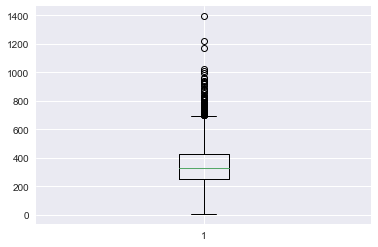

In [10]:
plt.boxplot(res['word_count']);

### TASK 3

Create a transformation pipeline:
  
  1. CountVectorizer (includes text preprocessing, tokenizing and filtering of stopwords are all included)
  2. TfidfTransformer
  3. Naive Bayes Classifier

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vect = CountVectorizer(lowercase=True, stop_words='english', analyzer='word')
tfidf = TfidfTransformer()
clf = MultinomialNB()

text_clf = Pipeline([
                    ('vect', vect),
                    ('tfidf', tfidf),
                    ('clf', clf),
                    ])

In [12]:
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy:", sum(predicted == y_test)/len(y_test))

Accuracy: 0.772


## TASK 4

Create a new pipeline that finishes with `LatentDirichletAllocation`.

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation()

lda_modl = Pipeline([
                    ('vect', vect),
                    ('clf', lda),
                    ])

In [14]:
lda_modl.fit(X_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                                           evaluate_every=-1,
                                           learning_decay=0.7,
                                           learning_method='batch',
                                

## TASK 5

Use PyLDAvis to create a visualization that explores the data.  If you were not using a pipeline the code would look something like this.

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [15]:
tf_vectorizer = CountVectorizer(stop_words='english',
                               lowercase=True,
                               max_df=0.5,
                               min_df=0.1)

dtm_tf = tf_vectorizer.fit_transform(df['text'])
print(dtm_tf.shape)

(2000, 343)


In [16]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=42)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [20]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, sort_topics=True)

C:\Users\Michael\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.071927 -0.075249       1        1  21.491231
6     -0.067650 -0.018091       2        1  12.688978
9      0.021081 -0.014111       3        1  12.353320
1     -0.040405  0.045291       4        1   9.516242
2      0.078059  0.006124       5        1   9.281253
4      0.060641  0.041930       6        1   9.021196
5      0.019192 -0.018932       7        1   7.208800
8     -0.006975  0.017921       8        1   6.792715
0     -0.100125 -0.067165       9        1   6.466549
3     -0.035746  0.082282      10        1   5.179716, topic_info=    Category         Freq      Term        Total  loglift  logprob
3    Default  1164.000000    action  1164.000000  30.0000  30.0000
72   Default   644.000000   effects   644.000000  29.0000  29.0000
91   Default   638.000000    family   638.000000  28.0000  28.0000
279  Default   570.000000   special   570.000000  27.0000  27.0000
40   Default   458.000000      city   458.000000  26.0000  26.0000
..       ...          ...       ...          ...      ...      ...
20   Topic10    76.985865      best  1331.687105   0.1098  -4.7555
65   Topic10    74.003462  director  1234.748100   0.1459  -4.7950
66   Topic10    60.762527      does  1568.717223  -0.2906  -4.9922
342  Topic10    54.752131     young   737.797852   0.3596  -5.0963
162  Topic10    54.808457      life  1580.574627  -0.4013  -5.0953

[515 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.133716    act
1         2  0.190018    act
1         3  0.080933    act
1         4  0.182980    act
1         5  0.042226    act
...     ...       ...    ...
342       6  0.027108  young
342       7  0.063703  young
342       8  0.077257  young
342       9  0.223638  young
342      10  0.074546  young

[2530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 10, 2, 3, 5, 6, 9, 1, 4])